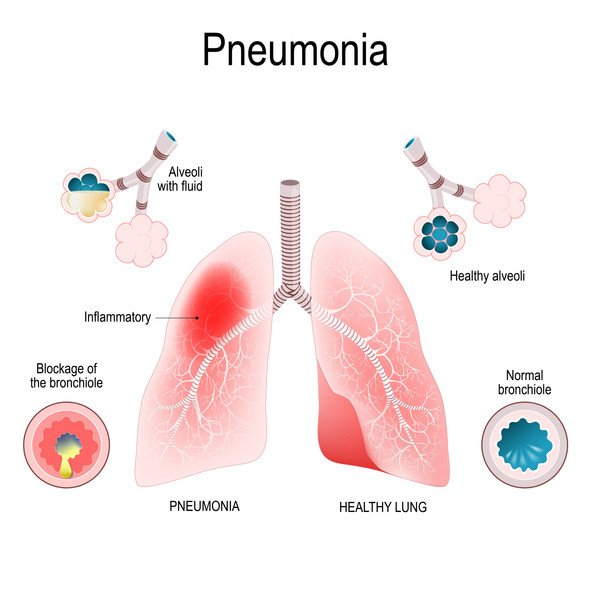

In [1]:
import os      
import numpy as np
import pandas as pd 
import cv2   
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib import rc
from pylab import rcParams
import random

import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

sns.set(style='whitegrid', palette='muted', font_scale=1.4)
rcParams['figure.figsize'] = 14, 8


# Setting seeds for reproducibility
SEED = 548

def set_seed(seed):
    tf.random.set_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(SEED)

In [2]:
# Hyperparameters
img_dims = 150    
batch_size = 32

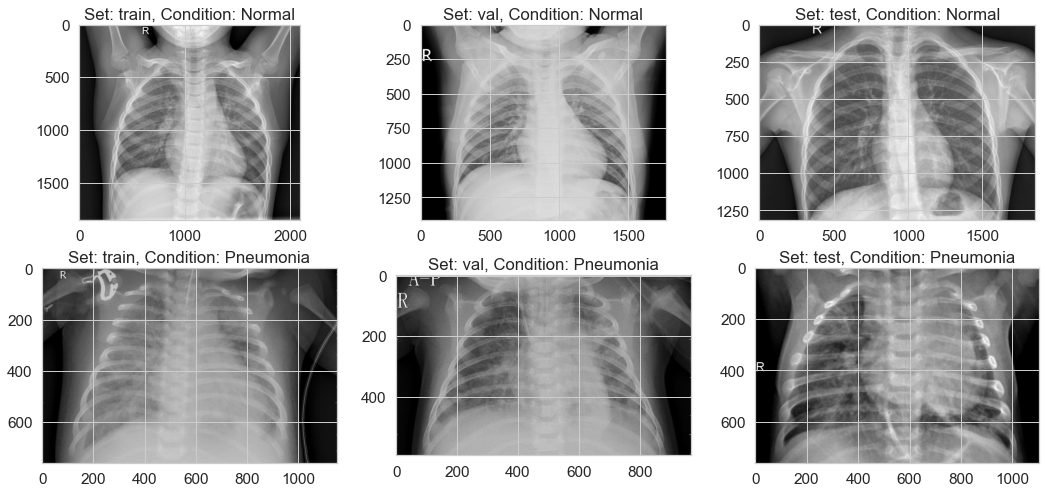

In [3]:
input_path="chest_xray/"
fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'val', 'test']):
    set_path = input_path+_set
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: Normal'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[0]), cmap='gray')
    ax[i+3].set_title('Set: {}, Condition: Pneumonia'.format(_set))

In [4]:
# Distribution of our datasets
for _set in ['train', 'val', 'test']:
    n_normal = len(os.listdir(input_path + _set + '/NORMAL'))
    n_infect = len(os.listdir(input_path + _set + '/PNEUMONIA'))
    print('Set: {}, Normal images: {}, pneumonia images: {}'.format(_set, n_normal, n_infect))

Set: train, Normal images: 1341, pneumonia images: 3875
Set: val, Normal images: 8, pneumonia images: 8
Set: test, Normal images: 234, pneumonia images: 390


In [5]:
# Hyperparameters
img_dims = 150    
batch_size = 32   

Data Augmentation

In [6]:
image_gen_train = ImageDataGenerator( 
rescale=1./255,
rotation_range=45,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True,
fill_mode='nearest') 



train_gen = image_gen_train.flow_from_directory(
directory=input_path+'train', 
target_size=(img_dims, img_dims), 
batch_size=batch_size, 
class_mode='binary', 
shuffle=True)


Found 5216 images belonging to 2 classes.


applying Data Augmentation


In [7]:
def process_data(img_dims, batch_size):
   
    train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True)
    
   
    train_gen = train_datagen.flow_from_directory(
    directory=input_path+'train', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    seed=SEED,
    shuffle=True)

    test_val_datagen = ImageDataGenerator(rescale=1./255)
    
    test_gen = test_val_datagen.flow_from_directory(
    directory=input_path+'test', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    seed=SEED,
    shuffle=True)
    
   
    test_data = []
    test_labels = []

    for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(input_path + 'test' + cond)):
            img = plt.imread(input_path+'test'+cond+img)
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond=='/NORMAL/':
                label = 0
            elif cond=='/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)
        
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return train_gen, test_gen, test_data, test_labels

In [8]:
train_gen, test_gen, test_data, test_labels = process_data(img_dims, batch_size)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [9]:
print (train_gen.class_indices.keys())

dict_keys(['NORMAL', 'PNEUMONIA'])


In [49]:
print(test_gen.class_indices)

{'NORMAL': 0, 'PNEUMONIA': 1}


Defining Model

In [26]:
model = tf.keras.models.Sequential([
  
# First conv block
Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same',input_shape=(img_dims, img_dims, 3)), 
Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'),
MaxPool2D(pool_size=(2, 2)),

# Second conv block
SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
BatchNormalization(),
MaxPool2D(pool_size=(2, 2)),
Dropout(rate=0.2),

# Third conv block
SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
BatchNormalization(),
MaxPool2D(pool_size=(2, 2)),
Dropout(rate=0.2),

# Fourth conv block
SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
BatchNormalization(),
MaxPool2D(pool_size=(2, 2)),
Dropout(rate=0.2),

# Fifth conv block
SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
BatchNormalization(),
MaxPool2D(pool_size=(2, 2)),
Dropout(rate=0.2),

# FC layer
Flatten(), 
Dense(units=512, activation='relu'),
Dropout(rate=0.7),
Dense(units=128, activation='relu'),
Dropout(rate=0.5),
Dense(units=64, activation='relu'),
Dropout(rate=0.3),


Dense(units=1, activation='sigmoid') 
])


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')  
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

Summary

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 16)       0         
 )                                                               
                                                                 
 separable_conv2d (Separable  (None, 75, 75, 32)       688       
 Conv2D)                                                         
                                                                 
 separable_conv2d_1 (Separab  (None, 75, 75, 32)       1344      
 leConv2D)                                                       
                                                        

Fitting Model

In [28]:
epochs = 15

# Fitting the model
hist = model.fit(
           train_gen, steps_per_epoch=train_gen.samples // batch_size, 
           epochs=epochs, validation_data=test_gen, 
           validation_steps=test_gen.samples // batch_size, callbacks=[checkpoint, lr_reduce])

Epoch 1/15
163/163 [==============================] - 127s 759ms/step - loss: 0.3806 - accuracy: 0.8236 - val_loss: 1.2803 - val_accuracy: 0.6283 - lr: 0.0010
Epoch 2/15
163/163 [==============================] - 117s 714ms/step - loss: 0.2940 - accuracy: 0.8712 - val_loss: 0.9708 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 3/15
163/163 [==============================] - ETA: 0s - loss: 0.2776 - accuracy: 0.8832
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 119s 728ms/step - loss: 0.2776 - accuracy: 0.8832 - val_loss: 0.7885 - val_accuracy: 0.6217 - lr: 0.0010
Epoch 4/15
163/163 [==============================] - 118s 720ms/step - loss: 0.2582 - accuracy: 0.8942 - val_loss: 0.7740 - val_accuracy: 0.6250 - lr: 3.0000e-04
Epoch 5/15
163/163 [==============================] - ETA: 0s - loss: 0.2445 - accuracy: 0.9047
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
163/163 [==================

Accuracy


In [51]:
from sklearn.metrics import accuracy_score, confusion_matrix

preds = model.predict(test_data)

acc = accuracy_score(test_labels, np.round(preds))*100



print('\nTEST METRICS ----------------------')

print('Accuracy: {}%'.format(acc))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((hist.history['accuracy'][-1])*100, 2)))


TEST METRICS ----------------------
Accuracy: 87.5%

TRAIN METRIC ----------------------
Train acc: 92.18


Generating a SavedModel

In [31]:
export_dir = 'saved_model/Pneumonia'
tf.saved_model.save(model, export_dir)

INFO:tensorflow:Assets written to: saved_model/Pneumonia\assets



Converting the SavedModel to TFLite For Using in Android App


In [32]:
import pathlib
tflite_model_name = "pneumonia_detection.tflite"
# Convert the model.
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

In [33]:
tflite_model_file = pathlib.Path(tflite_model_name)
tflite_model_file.write_bytes(tflite_model)

2376800